### 🎯 Error Map Visualization (Absolute & Relative)

이 시각화는 모델이 **어떤 공간 구조에서 밀도를 과대/과소 예측하는지** 직접 비교하기 위한 것입니다.

#### 1) Absolute Error Map (절대오차맵)
$$
E_{\text{abs}} = \log(1+\rho_{\text{pred}}) - \log(1+\rho_{\text{true}})
$$



- `log1p(ρ)` 공간에서의 절대 차이
- 고밀도 구조의 **형태 차이** 및 예측된 필라멘트/노드 대응 등을 확인할 때 유용
- Red → 모델이 **과대 예측**, Blue → **과소 예측**

#### 2) Relative Error Map (상대오차맵)
$$
E_{\text{rel}} = \frac{\rho_{\text{pred}} - \rho_{\text{true}}}{\rho_{\text{true}} + \epsilon}
$$


- 실제 밀도 대비 **비율 차이**
- 특히 **void(저밀도 영역)** 에서 모델 안정성 확인 가능
- ε는 ρ≈0 에서 발산 방지용 안정화 상수

#### 색상 스케일
- 두 경우 모두 **color range를 ±99% percentile로 대칭 설정**
- 즉, 극단치(소수 픽셀) 영향 제거 → 구조 비교가 명확해짐

#### 해석 가이드
| 색 | 의미 | 해석 포인트 |
|---|---|---|
| 🔴 양수 | 모델이 **과대 예측** | 해당 구조에서 밀도를 더 부풀려 추정 |
| 🔵 음수 | 모델이 **과소 예측** | 구조가 충분히 재구성되지 않음 |
| ⚪ 0 근처 | 예측이 정확함 | 모델이 해당 영역의 물리 구조를 잘 반영함 |



> **요약:**  
> Absolute Error → 구조적 차이 분석  
> Relative Error → Void 및 low-density 영역에서의 안정성 평가


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # [중요] cmap/mappable용
from typing import Tuple

def to_DHW(a: np.ndarray) -> np.ndarray:
    """
    입력 배열을 (D,H,W)로 표준화.
    허용 형태: (D,H,W), (H,W,D), (C,D,H,W), (N,C,D,H,W), (N,D,H,W)
    주의: '가장 긴 축이 D'라는 휴리스틱을 사용하므로, 데이터 스펙을 알고 있으면
         명시적 transpose(예: a.transpose(2,0,1))가 더 안전합니다.
    """
    a = np.asarray(a)
    # 앞쪽의 길이 1인 축(N=1, C=1 등)을 최대 2회 제거
    while a.ndim > 3 and a.shape[0] == 1:
        a = a[0]
    while a.ndim > 3 and a.shape[0] == 1:
        a = a[0]

    if a.ndim == 5:          # (N,C,D,H,W) -> 첫 샘플, 첫 채널 선택
        a = a[0, 0]
    elif a.ndim == 4:        # (N,D,H,W) or (C,D,H,W)
        a = a[0]
    elif a.ndim != 3:
        raise ValueError(f"Unsupported shape: {a.shape}")

    # (H,W,D) 케이스 추정: 최댓값인 축이 마지막이면 (2,0,1)로 transpose
    # (데이터 사양을 알면 여기를 고정 transpose로 바꾸세요.)
    if a.shape[2] == max(a.shape) and a.shape[0] != max(a.shape):
        a = a.transpose(2, 0, 1)  # (H,W,D) -> (D,H,W)

    return a  # (D,H,W) 가정

# ----------------- 사용자 설정 -----------------
index = '0'  # 문자열/정수 모두 가능(파일명에 맞춤)
base_path = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions/"
unet_pred_path = "/home/mingyeong/GAL2DM_ASIM_VNET/results/unet_predictions/28845/icase-both-keep2"
vit_pred_path  = "/home/mingyeong/GAL2DM_ASIM_ViT/results/vit_predictions/28846/icase-both"
true_test_path = f"/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{index}.hdf5"
# ------------------------------------------------

# ---- 데이터 로드 ----
with h5py.File(true_test_path, 'r') as f:
    rho_true = f['output_rho'][:]      # 타깃: 실제 밀도 ρ

with h5py.File(f"{unet_pred_path}/{index}.hdf5", 'r') as f:
    rho_pred_unet = f['prediction'][:] # UNet 예측 (ρ로 학습했다면 추가 변환 불필요)

with h5py.File(f"{vit_pred_path}/{index}.hdf5", 'r') as f:
    rho_pred_vit = f['prediction'][:]  # ViT 예측

# base_raw가 log10(ρ)/2.5 형식이라고 '가정' -> ρ로 역변환
base_raw = np.load(
    f"{base_path}test_{index}_final_mode0_lr_min1e-07_max1e-05_200epochs_rho_240712_a100_cmb_f2.5.npy"
)
rho_base = 10**(2.5 * base_raw)
# ⚠️ 만약 base가 log10(1+δ)/2.5였다면:
# rho_base = (10**(2.5 * base_raw) - 1) * rho_true.mean()

# ---- (D,H,W)로 표준화 ----
rho_true      = to_DHW(rho_true)
rho_pred_unet = to_DHW(rho_pred_unet)
rho_pred_vit  = to_DHW(rho_pred_vit)
rho_base      = to_DHW(rho_base)

# ---- 기본 통계/유효값 체크(빠른 sanity) ----
def stats(name, a):
    print(f"{name:>6s} | shape={a.shape}  "
          f"min={a.min():.3g}  max={a.max():.3g}  mean={a.mean():.3g}")
for n, a in [("true", rho_true), ("base", rho_base),
             ("unet", rho_pred_unet), ("vit", rho_pred_vit)]:
    stats(n, a)
    assert np.isfinite(a).all(), f"{n} contains NaN/Inf"

# ---- 투영(평균) + log1p(ρ) ----
proj = lambda x: x.mean(axis=0)  # (D,H,W)->(H,W). 단층(slice)을 보고 싶으면 x[D//2] 등 사용.
P_true = np.log1p(proj(rho_true))
P_base = np.log1p(proj(rho_base))
P_unet = np.log1p(proj(rho_pred_unet))
P_vit  = np.log1p(proj(rho_pred_vit))

# ---- 공통 컬러스케일(norm) 계산 ----
imgs = [P_true, P_base, P_unet, P_vit]
stack = np.concatenate([im.ravel() for im in imgs])
vmin, vmax = np.percentile(stack, [1, 99])  # 극단치 배제(필요 시 0.5–99.5 등 조정)

cmap = cm.get_cmap("cividis")
norm = plt.Normalize(vmin=vmin, vmax=vmax)  # [중요] 4개 패널에 공통 적용

  true | shape=(128, 128, 128)  min=0.0394  max=378  mean=1
  base | shape=(128, 128, 128)  min=0.0813  max=88.4  mean=0.784
  unet | shape=(128, 128, 128)  min=0  max=188  mean=1
   vit | shape=(128, 128, 128)  min=-0.14  max=231  mean=0.959


/tmp/ipykernel_3654611/495501701.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis")


/tmp/ipykernel_3654611/2720662972.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


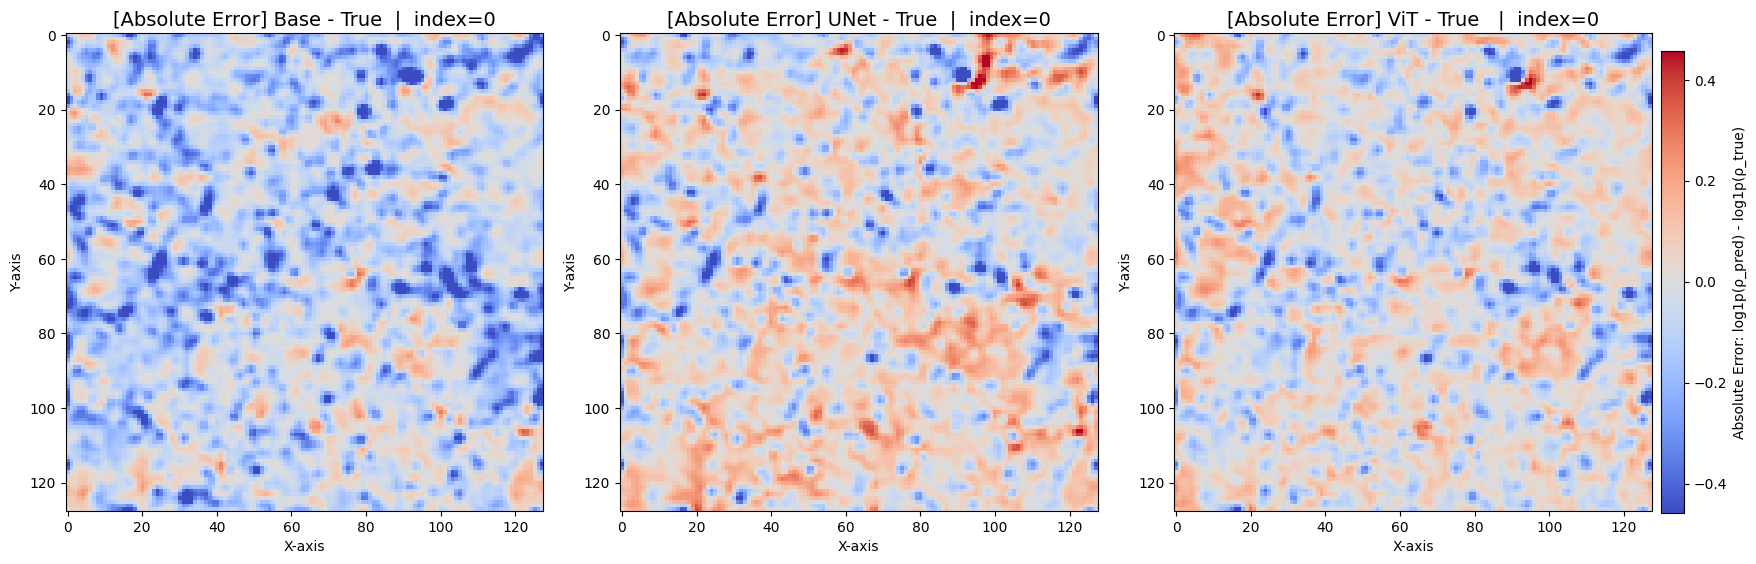

In [3]:
### 🔥 절대오차맵 (Absolute Error Map in log1p(ρ) Space) ###
# E = log1p(ρ_pred) - log1p(ρ_true)

# 절대오차 계산
E_base = P_base - P_true
E_unet = P_unet - P_true
E_vit  = P_vit  - P_true

# 컬러스케일을 대칭으로 설정 (over/under 추정 직관적 표현)
err_stack = np.concatenate([E_base.ravel(), E_unet.ravel(), E_vit.ravel()])
e = np.percentile(np.abs(err_stack), 99)   # 극단값 제외
vmin, vmax = -e, e

fig, ax = plt.subplots(1, 3, figsize=(19, 6))
titles = [
    f"[Absolute Error] Base - True  |  index={index}",
    f"[Absolute Error] UNet - True  |  index={index}",
    f"[Absolute Error] ViT - True   |  index={index}",
]

for i, err in enumerate([E_base, E_unet, E_vit]):
    im = ax[i].imshow(err, cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("X-axis")
    ax[i].set_ylabel("Y-axis")

# 공통 colorbar
fig.colorbar(im, ax=ax.ravel().tolist(),
             fraction=0.03, pad=0.04,
             label="Absolute Error: log1p(ρ_pred) - log1p(ρ_true)")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


/tmp/ipykernel_3654611/138266118.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


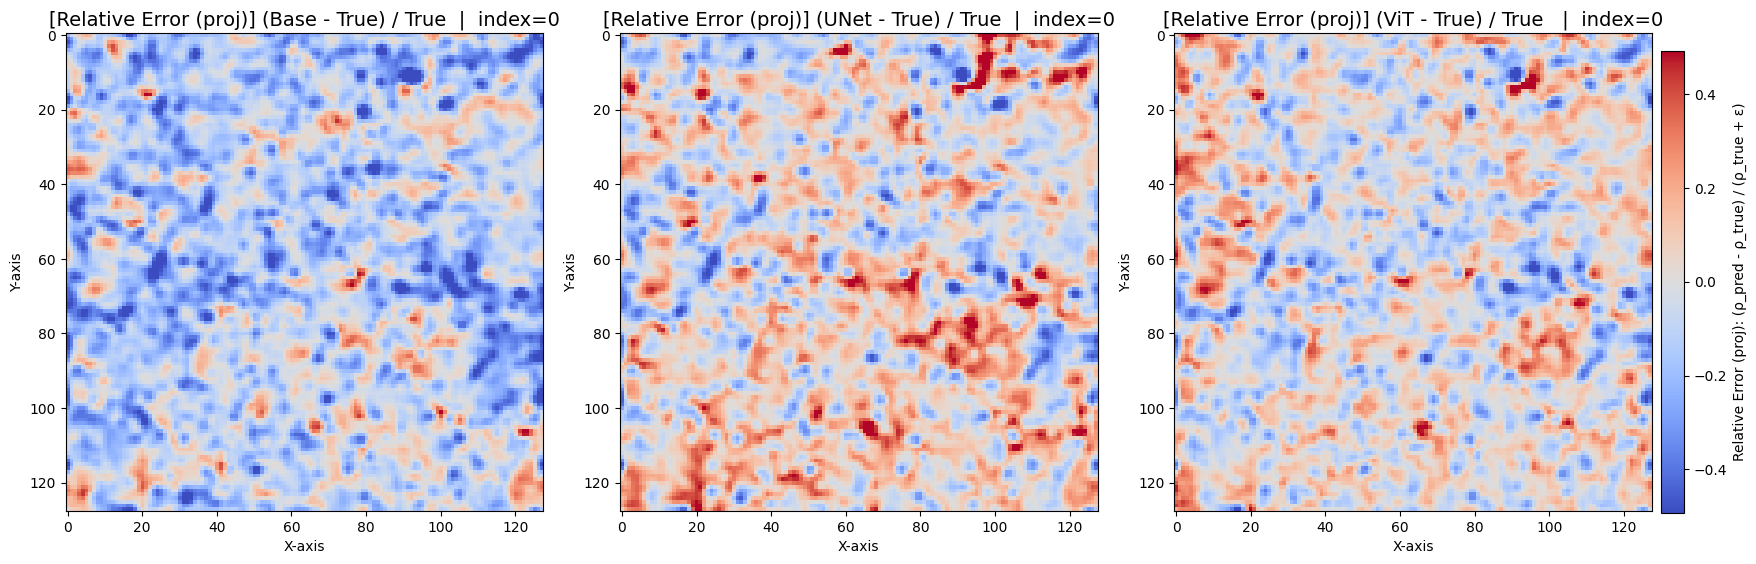

In [4]:
### 🔥 상대오차맵 (Relative Error Map on projected ρ) ###
# 먼저 2D로 투영된 ρ 맵을 사용
proj = lambda x: x.mean(axis=0)
rhoT = proj(rho_true)
rhoB = proj(rho_base)
rhoU = proj(rho_pred_unet)
rhoV = proj(rho_pred_vit)

eps2 = max(1e-8, np.percentile(rhoT, 1))  # 투영 후에도 안정화 필요

R_base = (rhoB - rhoT) / (rhoT + eps2)
R_unet = (rhoU - rhoT) / (rhoT + eps2)
R_vit  = (rhoV - rhoT) / (rhoT + eps2)

rel_stack = np.concatenate([R_base.ravel(), R_unet.ravel(), R_vit.ravel()])
r = np.percentile(np.abs(rel_stack), 99)
vmin, vmax = -r, r

fig, ax = plt.subplots(1, 3, figsize=(19, 6))
titles = [
    f"[Relative Error (proj)] (Base - True) / True  |  index={index}",
    f"[Relative Error (proj)] (UNet - True) / True  |  index={index}",
    f"[Relative Error (proj)] (ViT - True) / True   |  index={index}",
]

for i, err in enumerate([R_base, R_unet, R_vit]):
    im = ax[i].imshow(err, cmap="coolwarm", vmin=vmin, vmax=vmax)
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("X-axis"); ax[i].set_ylabel("Y-axis")

fig.colorbar(im, ax=ax.ravel().tolist(),
             fraction=0.03, pad=0.04,
             label="Relative Error (proj): (ρ_pred - ρ_true) / (ρ_true + ε)")

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
